# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

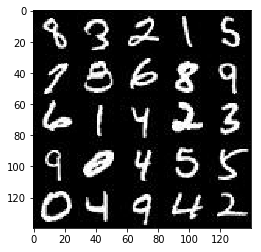

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

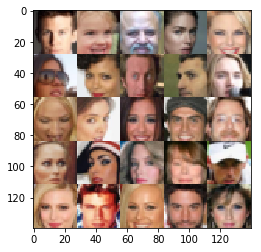

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2,padding='same')
        relu1 = tf.maximum(0.2*x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(0.2*bn2, bn2)
        
        flat = tf.reshape(relu2, (-1,4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse =  not is_train):
        x1 = tf.layers.dense(z,7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2*x1, x1)
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2*x2, x2)
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    real_inputs, z_inputs, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                # Run optimizers
                sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, learn_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, learn_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, learn_rate: learning_rate})
                steps += 1
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_inputs: batch_images, z_inputs: batch_z})
                    train_loss_g = g_loss.eval({real_inputs: batch_images, z_inputs: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 16, z_inputs, data_shape[3], data_image_mode)  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5043... Generator Loss: 0.4849
Epoch 1/2... Discriminator Loss: 1.6696... Generator Loss: 0.4071
Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.5746
Epoch 1/2... Discriminator Loss: 1.4466... Generator Loss: 0.6080
Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.6175
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.6343
Epoch 1/2... Discriminator Loss: 1.4404... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.6494


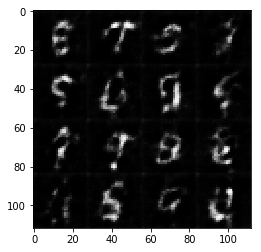

Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.6458
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 0.6723
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.6948
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.7050


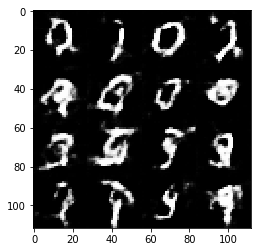

Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 0.6867
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 0.7167
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.7327
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 0.7288


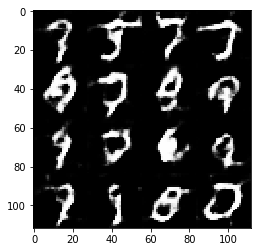

Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.6987
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.6755
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.7408
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 0.7377
Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.7750
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.6945
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.6570
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.7384


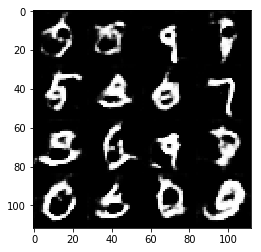

Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.7086
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.7582
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.2770... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.7258
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.6615


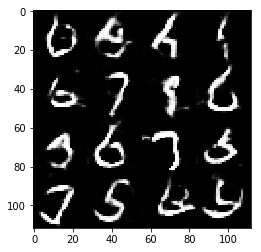

Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.7841
Epoch 2/2... Discriminator Loss: 1.3040... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.2797... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 0.6354
Epoch 2/2... Discriminator Loss: 1.3429... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.2883... Generator Loss: 0.7362
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.6358
Epoch 2/2... Discriminator Loss: 1.3036... Generator Loss: 0.6777


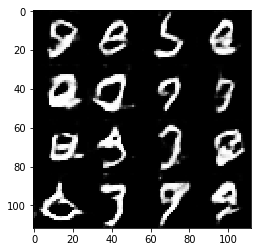

Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 0.7210
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.7745
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 0.6970
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.6797


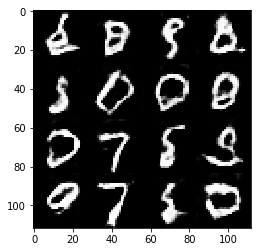

Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 1.3850... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.6959
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.2955... Generator Loss: 0.7426
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.3017... Generator Loss: 0.8405
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.6574


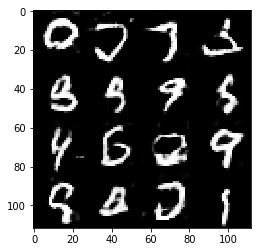

Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.6969
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.8127
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 0.7061
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.7104
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 0.7097
Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 0.7276
Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.7856
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.8030


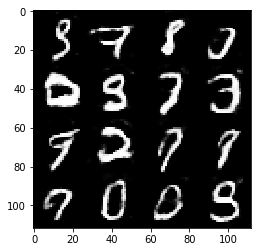

Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.9245


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0808... Generator Loss: 0.2648
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.6312


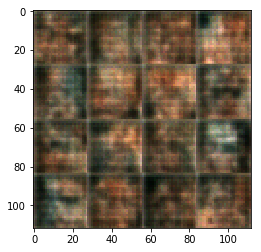

Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 2.2743... Generator Loss: 0.6040


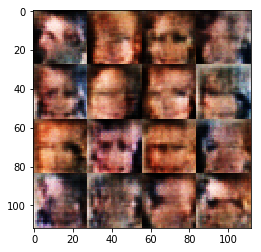

Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.3250
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.8207
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6882


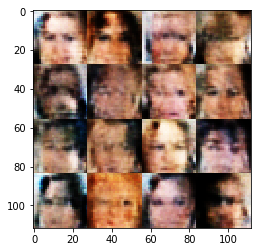

Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 12.4127... Generator Loss: 4.3520
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7512


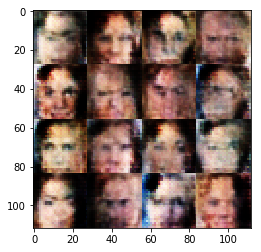

Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.6934


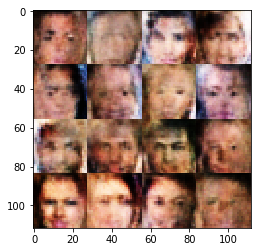

Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.8029


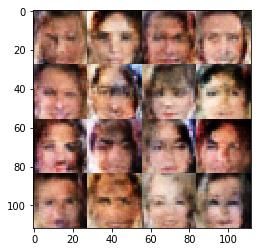

Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.8911


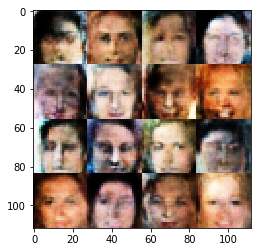

Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.8210


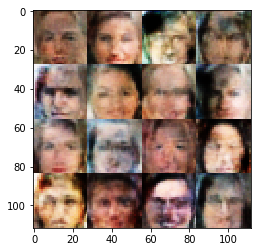

Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 1.1463
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.2099


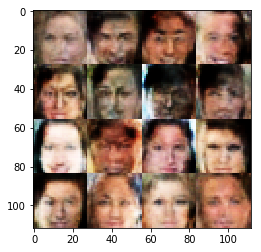

Epoch 1/1... Discriminator Loss: 2.7228... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.6191


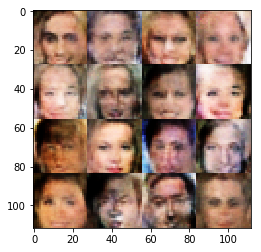

Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.7779


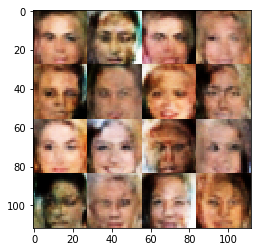

Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.4344
Epoch 1/1... Discriminator Loss: 1.9138... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7997


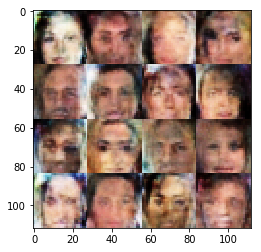

Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.6774


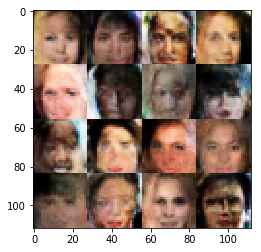

Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 7.6891... Generator Loss: 2.3462
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.6762


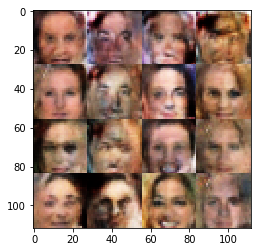

Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.7190


KeyboardInterrupt: 

In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.